# 1) Mounting drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/ladi-vton

/content/drive/MyDrive/ladi-vton


# 2) Installing dependencies

In [4]:
!pip install torch==2.0.1 torchvision==0.15.2 opencv-python==4.7.0.72 diffusers==0.14.0 transformers==4.27.3 accelerate==0.18.0 clean-fid==0.1.35 torchmetrics[image]==0.11.4 wandb==0.14.0 matplotlib==3.7.1 tqdm xformers  pyyaml==5.1 ninja av mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.0/167.0 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 32.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.4 MB/s eta 

*This Result needs to be TRUE*

In [2]:
import torch
torch.cuda.is_available()

True

# 3) Preprocessing human images

### Cleaning '/input' and '/results' folder

In [9]:
#Clear
import os
import glob
import shutil
from PIL import Image

files = glob.glob('input/*/*/*.*')        # removing all files from the 'input' folder
for f in files:
  os.remove(f)

files = glob.glob('results/*/*/*.*')      # removing all files from the 'results' folder
for f in files:
  os.remove(f)

### Load Humans and Text pairs

#### Resizing the image and pasting it over white background

In [10]:
def resize_with_pad(img, target_width, target_height):
    '''
    Resize PIL image keeping ratio and using white background.
    '''
    target_ratio = target_height / target_width
    img_ratio = img.height / img.width
    if target_ratio > img_ratio:
        # It must be fixed by width
        resize_width = target_width
        resize_height = round(resize_width * img_ratio)
    else:
        # Fixed by height
        resize_height = target_height
        resize_width = round(resize_height / img_ratio)

    image_resize = img.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (target_width, target_height), (255, 255, 255, 255))             # creating new image of white background
    offset = (round((target_width - resize_width) / 2), round((target_height - resize_height) / 2))
    background.paste(image_resize, offset)            # Pasting the original image on white background
    return background.convert('RGB')

In [11]:
#Add pairs
def write_row(file_, *columns):
    print(*columns, sep='\t', end='\n', file=file_)

upper = open('input/upper_body/test_pairs_unpaired.txt', 'w')       # this file contains multiple rows having 2 columns: i) the human image name  ii) the cloth image name that wants to be fitted on upper body of the human
lower = open('input/lower_body/test_pairs_unpaired.txt', 'w')       # this file contains multiple rows having 2 columns: i) the human image name  ii) the cloth image name that wants to be fitted on upper body of the human
dresses = open('input/dresses/test_pairs_unpaired.txt', 'w')        # this file contains multiple rows having 2 columns: i) the human image name  ii) the cloth image name that wants to be fitted on the whole body of the human
all = open('input/test_pairs_paired.txt', 'w')                      # this file contains multiple rows having 2 columns: i) the human image name  ii) the cloth image name that wants to be fitted anywhere upon the human image

with open('images/test_pairs.txt', "r") as file:      # this test_pairs file contains 3 columns: i) the name of the human image   ii) the name of the cloth image   iii) the integer value ranging from 0 to 2: 0 represents the cloth is of upper body, 1 represents the cloth is of lower body and 2 represents the cloth is fitting the whole body
    data = file.readlines()
    for line in data:
        word = line.split()                         # word = [02_0.jpg, 7_1.jpg 1, 1]
        org_path = 'images/humans/' + word[0]       # the name of the image in 'images/human' upon which we want to fit the cloth


        if(word[2] == '0'):     # => we want to fit something on the upper body of the person
          write_row(upper,'0'+word[0],word[1])      # writing info to 'upper' file
          write_row(all,'0'+word[0],word[1],word[2])
          res_path = 'input/upper_body/images/0' + word[0]        # in this res_path, we will store all the pre-processed human images upon which we want to fit the upper body cloth

        elif(word[2] == '1'):   # => we want to fit something on the lower body of the person
          write_row(lower,'1'+word[0],word[1])
          write_row(all,'1'+word[0],word[1],word[2])
          res_path = 'input/lower_body/images/1' + word[0]

        elif(word[2] == '2'):   # => we want to fit some dress which covers both the upper as well as the lower portion of the body
          write_row(dresses,'2'+word[0],word[1])
          write_row(all,'2'+word[0],word[1],word[2])
          res_path = 'input/dresses/images/2' + word[0]


        image = Image.open(org_path)        # opening the human image
        new = resize_with_pad(image,384,512)      # resizing the human image and making the background colour of the image as white
        new.save(res_path)

upper.close()
lower.close()
dresses.close()
all.close()

<ipython-input-10-c1ab6af6c1cc>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image_resize = img.resize((resize_width, resize_height), Image.ANTIALIAS)


## Openpose

In [12]:
%cd preprocess

/content/drive/MyDrive/ladi-vton/preprocess


In [13]:
# !git clone https://github.com/Hzzone/pytorch-openpose.git
%cd pytorch-openpose

/content/drive/MyDrive/ladi-vton/preprocess/pytorch-openpose


In [14]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import copy
import numpy as np
import glob
import json
import os

from src import model
from src import util
from src.body import Body
from src.hand import Hand

body_estimation = Body('model/body_pose_model.pth')

for s in ['upper_body','lower_body','dresses']:
  input_path = '/content/drive/MyDrive/ladi-vton/input/' + s + '/images/'
  output_path = '/content/drive/MyDrive/ladi-vton/input/'+ s + '/skeletons/'
  keypoint_path = '/content/drive/MyDrive/ladi-vton/input/'+ s + '/keypoints/'


  for images in glob.glob('*',root_dir = input_path):         # for each image present in the above mentioned input path. (Note: As of now, the input path only contains the human images and not the dress images)
      oriImg = cv2.imread(input_path+images)  # B,G,R order
      candidate, subset = body_estimation(oriImg)
      canvas = util.draw_bodypose(np.zeros_like(oriImg), candidate, subset)
      arr = candidate.tolist()

      vals = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0]
      # vals contains the following attributes of the clothing: ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']

      for i in range(0,18):
        if len(arr)==i or arr[i][3] != vals[i]:
          arr.insert(i,[-1,-1,-1,vals[i]])      # inserting [-1,-1,-1,vals[i]] at the ith index of arr

      keypoints = {'keypoints':arr[:18]}        # creating dictionary 'keypoints' with value as: slicing the arr to include the first 18 elements
      cv2.imwrite(output_path + images.replace('_0','_5'),canvas)     # saving the skeletons of the (human) images
      with open(keypoint_path+ os.path.splitext(images)[0].replace('_0','_2') +".json" , 'w') as fin:
        fin.write(json.dumps(keypoints))

In [15]:
%cd ../..

/content/drive/MyDrive/ladi-vton


## Human Label Parse


In [16]:
%cd preprocess

/content/drive/MyDrive/ladi-vton/preprocess


In [17]:
# !git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing
%cd Self-Correction-Human-Parsing

/content/drive/MyDrive/ladi-vton/preprocess/Self-Correction-Human-Parsing


# Saving at 'input/upper_body/label_maps' folder

In [18]:
!python simple_extractor.py --dataset 'atr' --model-restore '/content/drive/MyDrive/ladi-vton/preprocess/Self-Correction-Human-Parsing/checkpoints/final.pth' --input-dir '/content/drive/MyDrive/ladi-vton/input/upper_body/images/' --output-dir '/content/drive/MyDrive/ladi-vton/input/upper_body/label_maps/'

Evaluating total class number 18 with ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']
100% 3/3 [00:00<00:00,  3.37it/s]


In [19]:
!python simple_extractor.py --dataset 'atr' --model-restore '/content/drive/MyDrive/ladi-vton/preprocess/Self-Correction-Human-Parsing/checkpoints/final.pth' --input-dir '/content/drive/MyDrive/ladi-vton/input/lower_body/images/' --output-dir '/content/drive/MyDrive/ladi-vton/input/lower_body/label_maps/'

Evaluating total class number 18 with ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']
100% 3/3 [00:00<00:00,  4.40it/s]


In [20]:
!python simple_extractor.py --dataset 'atr' --model-restore '/content/drive/MyDrive/ladi-vton/preprocess/Self-Correction-Human-Parsing/checkpoints/final.pth' --input-dir '/content/drive/MyDrive/ladi-vton/input/dresses/images/' --output-dir '/content/drive/MyDrive/ladi-vton/input/dresses/label_maps/'

Evaluating total class number 18 with ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']
100% 2/2 [00:00<00:00,  2.73it/s]


In [21]:
%cd ../..

/content/drive/MyDrive/ladi-vton


## DensePose


In [22]:
%cd preprocess

/content/drive/MyDrive/ladi-vton/preprocess


In [23]:
# !python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions

# !git clone 'https://github.com/facebookresearch/detectron2'

# Installing dependencies for detectron2. The dependencies are mentioned in '/detectron2/setup.py' file
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=7bda54a37cb7fa4e64f8c621e775d48602e7a5bf4c8d93f1a108d5eff96a3326
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=eef514caf4df7fed98d813611f915fe37c4df8cd8980494128a6245f90e11057
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127ed

In [24]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [25]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [26]:
%cd detectron2/projects/DensePose

/content/drive/MyDrive/ladi-vton/preprocess/detectron2/projects/DensePose


# Show config at 'input/upper_body/dense' folder

In [27]:
!python apply_net.py show configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/ladi-vton/input/upper_body/images dp_segm -v --output /content/drive/MyDrive/ladi-vton/input/upper_body/dense/

[08/20 20:42:47 apply_net]: Loading config from configs/densepose_rcnn_R_50_FPN_s1x.yaml
[08/20 20:42:48 apply_net]: Loading model from https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl
model_final_162be9.pkl: 256MB [00:03, 74.6MB/s]              
[08/20 20:43:08 apply_net]: Loading data from /content/drive/MyDrive/ladi-vton/input/upper_body/images
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[08/20 20:43:10 apply_net]: Processing /content/drive/MyDrive/ladi-vton/input/upper_body/images/002_0.jpg
[08/20 20:43:10 apply_net]: Output saved to /content/drive/MyDrive/ladi-vton/input/upper_body/dense/002_5.png
[08/20 20:43:10 apply_net]: Processing /content/drive/MyDrive/ladi-vt

In [28]:
!python apply_net.py show configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/ladi-vton/input/lower_body/images dp_segm -v  --output /content/drive/MyDrive/ladi-vton/input/lower_body/dense/

[08/20 20:43:21 apply_net]: Loading config from configs/densepose_rcnn_R_50_FPN_s1x.yaml
[08/20 20:43:21 apply_net]: Loading model from https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl
[08/20 20:43:22 apply_net]: Loading data from /content/drive/MyDrive/ladi-vton/input/lower_body/images
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[08/20 20:43:24 apply_net]: Processing /content/drive/MyDrive/ladi-vton/input/lower_body/images/102_0.jpg
[08/20 20:43:24 apply_net]: Output saved to /content/drive/MyDrive/ladi-vton/input/lower_body/dense/102_5.png
[08/20 20:43:24 apply_net]: Processing /content/drive/MyDrive/ladi-vton/input/lower_body/images/104_0.jpg
[08/20 20:43:24 apply_net

In [29]:
!python apply_net.py show configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/ladi-vton/input/dresses/images dp_segm -v   --output /content/drive/MyDrive/ladi-vton/input/dresses/dense/

[08/20 20:43:31 apply_net]: Loading config from configs/densepose_rcnn_R_50_FPN_s1x.yaml
[08/20 20:43:31 apply_net]: Loading model from https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl
[08/20 20:43:33 apply_net]: Loading data from /content/drive/MyDrive/ladi-vton/input/dresses/images
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[08/20 20:43:34 apply_net]: Processing /content/drive/MyDrive/ladi-vton/input/dresses/images/202_0.jpg
[08/20 20:43:34 apply_net]: Output saved to /content/drive/MyDrive/ladi-vton/input/dresses/dense/202_5.png
[08/20 20:43:34 apply_net]: Processing /content/drive/MyDrive/ladi-vton/input/dresses/images/217_0.jpg
[08/20 20:43:34 apply_net]: Output sa

# Dump config at 'input/upper_body/dense' folder

In [30]:
!python apply_net.py dump configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/ladi-vton/input/upper_body/images -v --output /content/drive/MyDrive/ladi-vton/input/upper_body/dense/

[08/20 20:43:43 apply_net]: Loading config from configs/densepose_rcnn_R_50_FPN_s1x.yaml
[08/20 20:43:43 apply_net]: Loading model from https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl
[08/20 20:43:45 apply_net]: Loading data from /content/drive/MyDrive/ladi-vton/input/upper_body/images
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[08/20 20:43:46 apply_net]: Processing /content/drive/MyDrive/ladi-vton/input/upper_body/images/002_0.jpg
[08/20 20:43:47 apply_net]: Processing /content/drive/MyDrive/ladi-vton/input/upper_body/images/03_0.jpg
[08/20 20:43:47 apply_net]: Processing /content/drive/MyDrive/ladi-vton/input/upper_body/images/014_0.jpg
[08/20 20:43:47 apply_net]: Ou

In [31]:
!python apply_net.py dump configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/ladi-vton/input/lower_body/images -v --output /content/drive/MyDrive/ladi-vton/input/lower_body/dense/

[08/20 20:43:54 apply_net]: Loading config from configs/densepose_rcnn_R_50_FPN_s1x.yaml
[08/20 20:43:54 apply_net]: Loading model from https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl
[08/20 20:43:55 apply_net]: Loading data from /content/drive/MyDrive/ladi-vton/input/lower_body/images
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[08/20 20:43:57 apply_net]: Processing /content/drive/MyDrive/ladi-vton/input/lower_body/images/102_0.jpg
[08/20 20:43:57 apply_net]: Processing /content/drive/MyDrive/ladi-vton/input/lower_body/images/104_0.jpg
[08/20 20:43:57 apply_net]: Processing /content/drive/MyDrive/ladi-vton/input/lower_body/images/16_0.jpg
[08/20 20:43:57 apply_net]: Ou

In [32]:
!python apply_net.py dump configs/densepose_rcnn_R_50_FPN_s1x.yaml \
https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl \
/content/drive/MyDrive/ladi-vton/input/dresses/images -v --output /content/drive/MyDrive/ladi-vton/input/dresses/dense/

[08/20 20:44:05 apply_net]: Loading config from configs/densepose_rcnn_R_50_FPN_s1x.yaml
[08/20 20:44:05 apply_net]: Loading model from https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl
[08/20 20:44:06 apply_net]: Loading data from /content/drive/MyDrive/ladi-vton/input/dresses/images
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[08/20 20:44:08 apply_net]: Processing /content/drive/MyDrive/ladi-vton/input/dresses/images/202_0.jpg
[08/20 20:44:08 apply_net]: Processing /content/drive/MyDrive/ladi-vton/input/dresses/images/217_0.jpg
[08/20 20:44:08 apply_net]: Output saved to /content/drive/MyDrive/ladi-vton/input/dresses/dense/202_5_uv.npz
[08/20 20:44:08 apply_net]: Output

In [33]:
%cd ../../../..

/content/drive/MyDrive/ladi-vton


In [34]:
from google.colab.patches import cv2_imshow
import cv2
import glob
pattern = 'input/*/dense/*'
mp ={0: 0, 128: 18, 64: 4, 132: 19, 69: 5, 136: 20, 75: 6, 140: 21, 145: 22, 85: 9, 150: 23, 90: 10, 155: 24, 121: 16, 105: 13, 111: 14, 52: 2, 117: 15, 57: 3, 124: 17,
     2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 9: 9, 10: 10, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24}

lut = np.zeros((256, 1), dtype=np.uint8)

for i in range(0,256):
    lut[i] = mp.get(i) or mp[min(mp.keys(), key = lambda key: abs(key-i))]

for images in glob.glob(pattern):
    if images.endswith(".png"):
      image = cv2.imread(images,cv2.IMREAD_GRAYSCALE)
      cv2.imwrite(images,cv2.LUT(image,lut))

# Processing cloth images
### Now, what all we did with human images, we would do the same with cloth images.

In [35]:
# First clear all the processed images of the humans from '/input' folder
import os
import glob
import shutil
from PIL import Image

files = glob.glob('input/*/*/*.*')
for f in files:
  if f.endswith("_1.jpg") or f.endswith("_1.png"):
    os.remove(f)

## Resizing cloth image and creating white background for these images

In [36]:
def resize_with_pad(im, target_width, target_height):
    '''
    Resize PIL image keeping ratio and using white background.
    '''
    target_ratio = target_height / target_width
    im_ratio = im.height / im.width
    if target_ratio > im_ratio:
        # It must be fixed by width
        resize_width = target_width
        resize_height = round(resize_width * im_ratio)
    else:
        # Fixed by height
        resize_height = target_height
        resize_width = round(resize_height / im_ratio)

    image_resize = im.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (target_width, target_height), (255, 255, 255, 255))
    offset = (round((target_width - resize_width) / 2), round((target_height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

In [37]:
for c in ['dresses','upper_body','lower_body']:
  files = glob.glob('images/'+c+'/*.*')
  path = 'input/' + c + '/images/'
  for f in files:
    if f.endswith("_1.jpg"):        # if an image name ends with _0 =>it is an human image. And if it ends with _1 => it is a cloth image
      res = path + os.path.basename(f)
      shutil.copy (f, res)
      image = Image.open(res)
      new = resize_with_pad(image,384,512)
      new.save(res)

<ipython-input-36-e04c8aed8ec9>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image_resize = im.resize((resize_width, resize_height), Image.ANTIALIAS)


## Creating Masks for each cloth and storing it in 'input/upper_body/masks' folder

In [38]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import copy
import glob
import json
import os

def otsu(img , n  , x ):
    img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(img_gray,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,n,x)
    return thresh

def contour(img):
    edges = cv2.dilate(cv2.Canny(img,200,255),None)
    cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
    mask = np.zeros((img.shape[0],img.shape[1]), np.uint8)
    masked = cv2.drawContours(mask, [cnt],-1, 255, -1)
    return masked

def get_cloth_mask(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(image)
    cv2.drawContours(mask, contours, -1, (255, 255, 255), -1)
    return mask

def write_edge(C_path,E_path):
    img = cv2.imread(C_path)
    res = get_cloth_mask(img)
    if(np.mean(res)<100):
        ot = otsu(img,11,0.6)
        res = contour(ot)
    cv2.imwrite(E_path,res)

for s in ['upper_body','lower_body','dresses']:
  input_path = '/content/drive/MyDrive/ladi-vton/input/' + s + '/images/'
  output_path = '/content/drive/MyDrive/ladi-vton/input/'+ s + '/masks/'
  for images in glob.glob('*',root_dir = input_path):
      if images.endswith("_1.jpg"):
        write_edge(input_path + images , output_path+ os.path.splitext(images)[0] +".png")

# Testing


In [39]:
import gc
gc.collect()

51

In [40]:
!sh test.sh

2023-08-20 20:45:11.045774: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of the model checkpoint at laion/CLIP-ViT-H-14-laion2B-s32B-b79K were not used when initializing CLIPVisionModelWithProjection: ['text_model.encoder.layers.10.layer_norm2.weight', 'text_model.encoder.layers.3.mlp.fc1.bias', 'text_model.encoder.layers.8.layer_norm2.bias', 'text_model.encoder.layers.19.self_attn.out_proj.weight', 'text_model.encoder.layers.6.self_attn.out_proj.bias', 'text_model.encoder.layers.18.self_attn.v_proj.weight', 'text_model.encoder.layers.3.self_attn.k_proj.bias', 'text_model.encoder.layers.8.mlp.fc1.weight', 'text_model.encoder.layers.22.layer_norm1.bias', 'text_model.encoder.layers.15.mlp.fc2.weight', 'text_model.encoder.layers.5.self_attn.k_proj.weight', 'text_model.encoder.layers.7.layer_norm1.weight', 'text_model.encoder.layers.23.self_attn.v_proj.bias', 'text_model.encoder.layers.12.layer_norm1.weight', 'text_model.encod

In [41]:
!sh metrics.sh

2023-08-20 20:53:08.901182: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
100% 3/3 [00:00<00:00, 692.40it/s]
Found 3 images in the folder /tmp/dresscode/lower_body
custom stats: lower_body : 100% 1/1 [00:00<00:00,  1.78it/s]
saving custom FID stats to /usr/local/lib/python3.10/dist-packages/cleanfid/stats/dresscode_lower_body_clean_custom_na.npz
saving custom KID stats to /usr/local/lib/python3.10/dist-packages/cleanfid/stats/dresscode_lower_body_clean_custom_na_kid.npz
100% 8/8 [00:00<00:00, 653.96it/s]
Found 8 images in the folder /tmp/dresscode/all
custom stats: all : 100% 1/1 [00:00<00:00,  4.29it/s]
saving custom FID stats to /usr/local/lib/python3.10/dist-packages/cleanfid/stats/dresscode_all_clean_custom_na.npz
saving custom KID stats to /usr/local/lib/python3.10/dist-packages/cleanfid/stats/dresscode_all_clean_custom_na_kid.npz
compute FID of a folder with dresscode_lower_body statistics
Found 3 images in the folder ./results/un

#Results

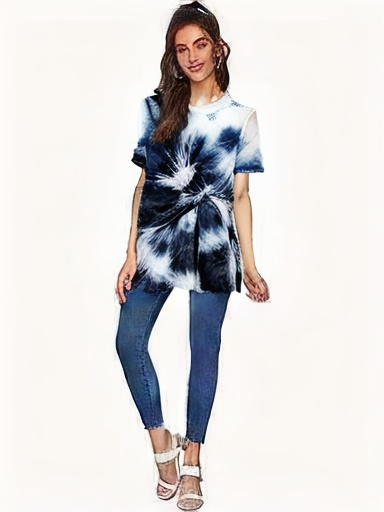

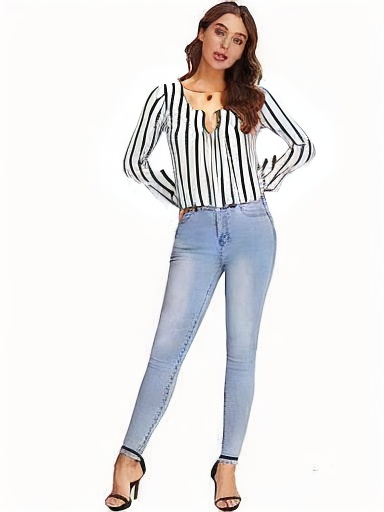

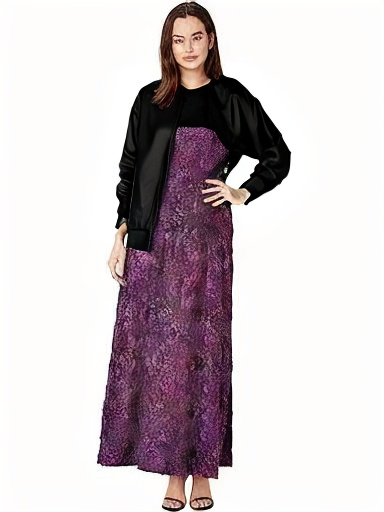

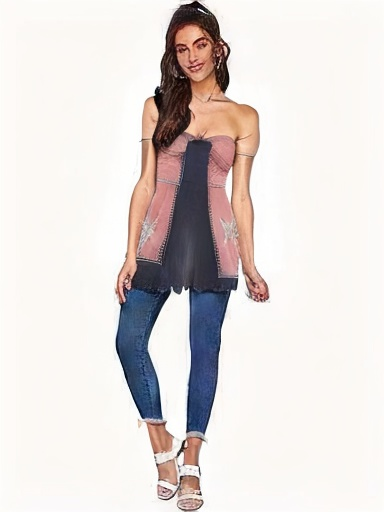

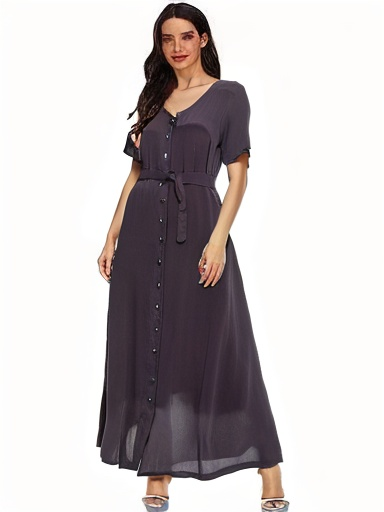

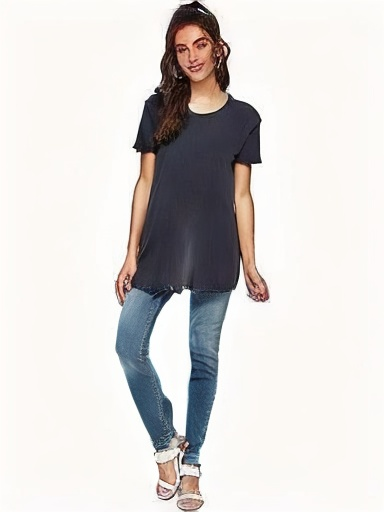

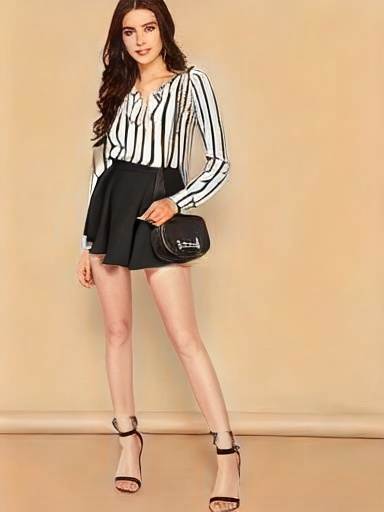

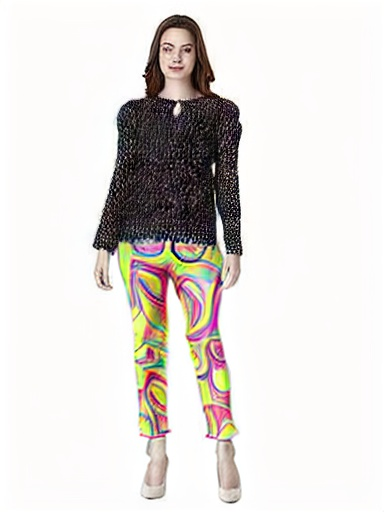

In [42]:
from google.colab.patches import cv2_imshow
import cv2
import glob

pattern = 'results/unpaired/*/*'
for images in glob.glob(pattern):
    if (images.endswith(".png") or images.endswith(".jpg") or images.endswith(".jpeg")):
      cv2_imshow(cv2.imread(images, cv2.IMREAD_UNCHANGED))

# Refining the distorted faces using mediapipe

In [43]:
import mediapipe
import cv2
import os
import glob
import mediapipe
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow

In [44]:
dresscode = 'final'

### Generator

In [45]:
filepath = os.path.join('input', f"test_pairs_paired.txt")
with open(filepath, 'r') as f:
    lines = f.read().splitlines()
org_paths = sorted(
      [os.path.join('input', category, 'images', line.strip().split()[0]) for line in lines for
        category in ['lower_body', 'upper_body', 'dresses'] if
        os.path.exists(os.path.join('input', category, 'images', line.strip().split()[0]))])
res_paths = sorted(
                [os.path.join('results/unpaired', category, name) for category in ['lower_body', 'upper_body', 'dresses'] for
                 name in os.listdir(os.path.join('results/unpaired', category)) if
                 os.path.exists(os.path.join('results/unpaired', category, name))])

In [46]:
assert len(org_paths) == len(res_paths)
sz = len(org_paths)

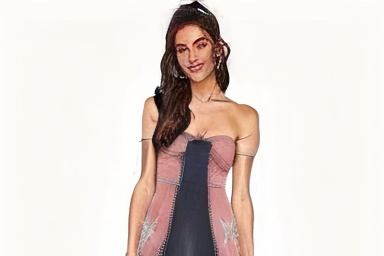

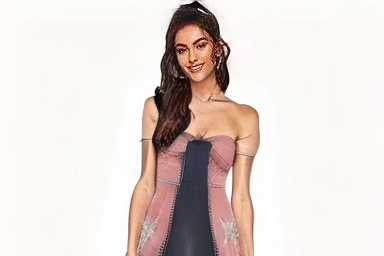

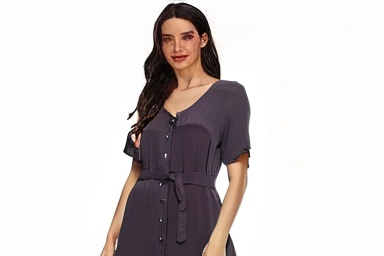

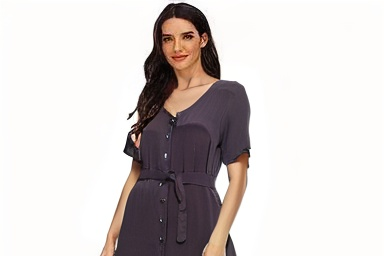

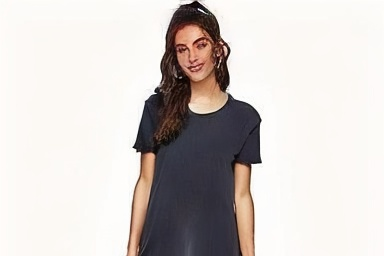

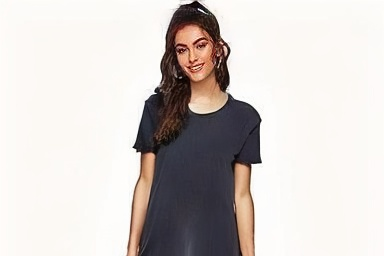

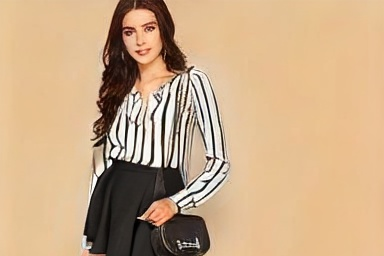

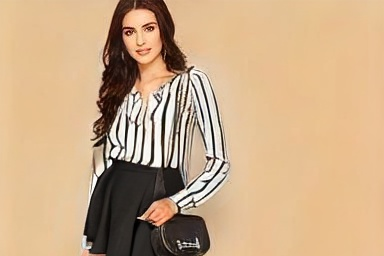

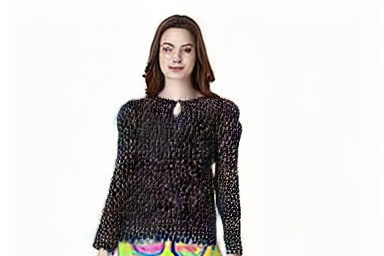

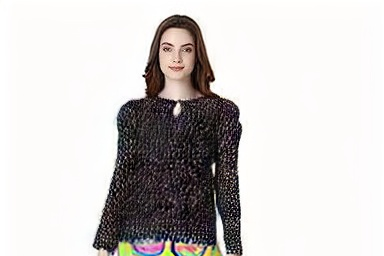

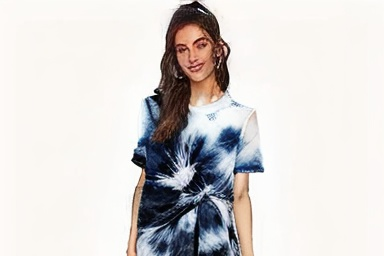

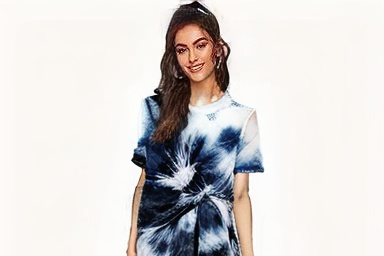

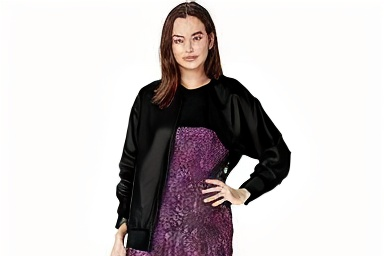

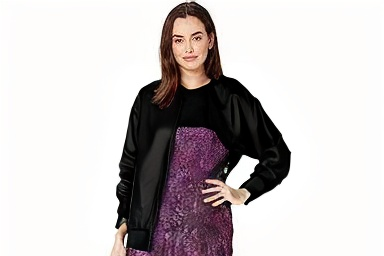

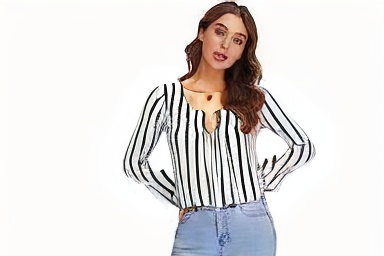

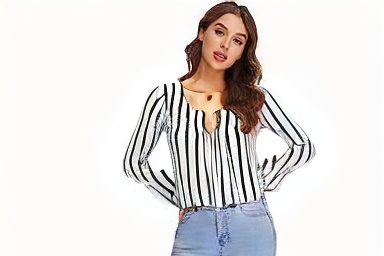

In [47]:
for iter in range(0,sz):
  org_img = cv2.imread(org_paths[iter])
  org_res = cv2.imread(res_paths[iter])
  h,w = int(org_img.shape[0]/2),org_img.shape[1]
  img = org_img[:h,:w]
  res = org_res[:h,:w]
  cv2_imshow(res)
  mp_face_mesh = mediapipe.solutions.face_mesh
  face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
  results = face_mesh.process(img[:,:,::-1])
  if(results.multi_face_landmarks == None):
     print('miss')
     continue
  landmarks = results.multi_face_landmarks[0]
  df = pd.DataFrame(list(mp_face_mesh.FACEMESH_FACE_OVAL),columns=['p1','p2'])
  routes_idx = []

  p2 = df.iloc[0]['p1']
  p2 = df.iloc[0]['p2']
  for i in range(0,df.shape[0]):
    obj = df[df['p1'] == p2]
    p1 = obj['p1'].values[0]
    p2 = obj['p2'].values[0]

    cur = []
    cur.append(p1)
    cur.append(p2)
    routes_idx.append(cur)

  routes = []
  for sid,tid in routes_idx:
    sxy = landmarks.landmark[sid]
    txy = landmarks.landmark[tid]

    source = (int(sxy.x * img.shape[1]) , int(sxy.y * img.shape[0]))
    target = (int(txy.x * img.shape[1]) , int(txy.y * img.shape[0]))

    routes.append(source)
    routes.append(target)

  mask = np.zeros((img.shape[0],img.shape[1]))
  mask = cv2.fillConvexPoly(mask,np.array(routes),1)
  mask = mask.astype(bool)
  res[mask] = img[mask]
  cv2_imshow(res)
  org_img[:h,:w] = img
  org_res[:h,:w] = res
  cv2.imwrite(res_paths[iter].replace('results/unpaired','final').replace('_0.jpg','_'+dresscode+'.jpg'),org_res)

# Final Result

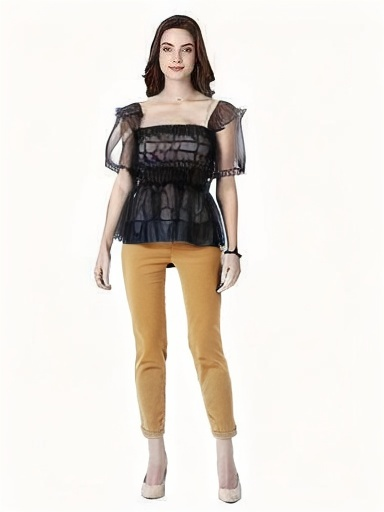

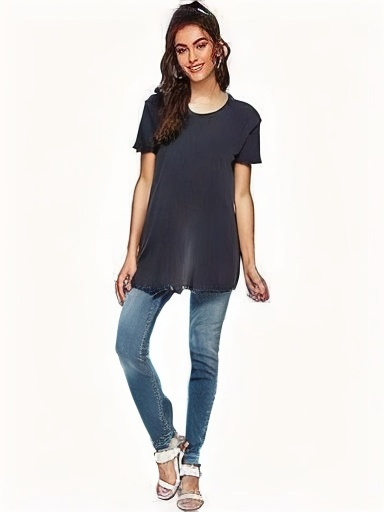

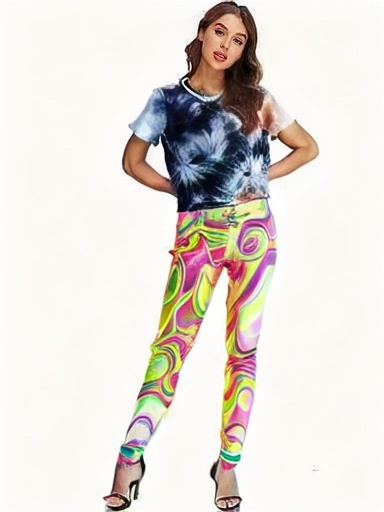

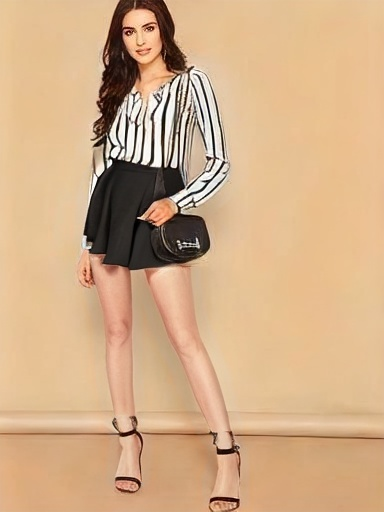

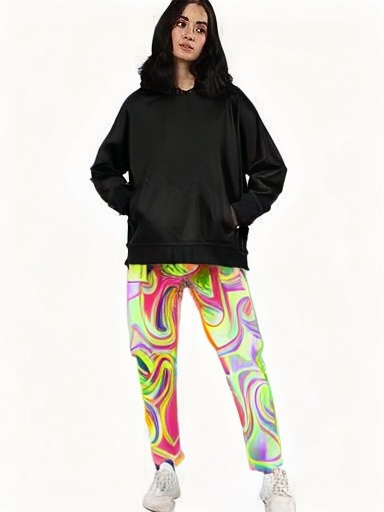

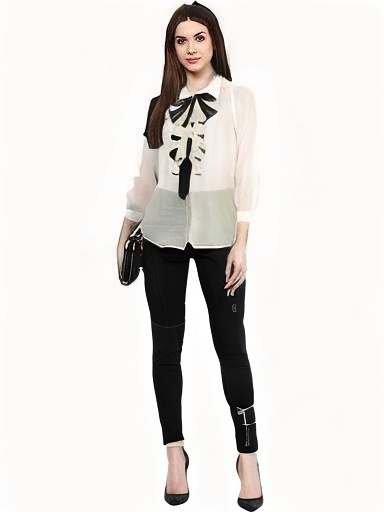

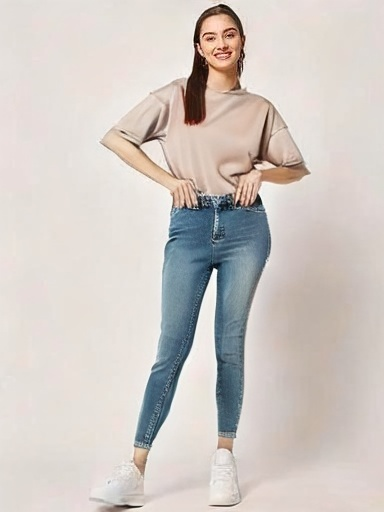

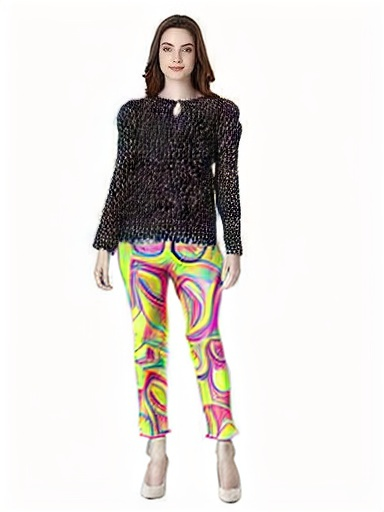

In [48]:
pattern = 'final/lower_body/*'
for images in glob.glob(pattern):
    if images.endswith( dresscode + ".jpg"):
      cv2_imshow(cv2.imread(images, cv2.IMREAD_UNCHANGED))

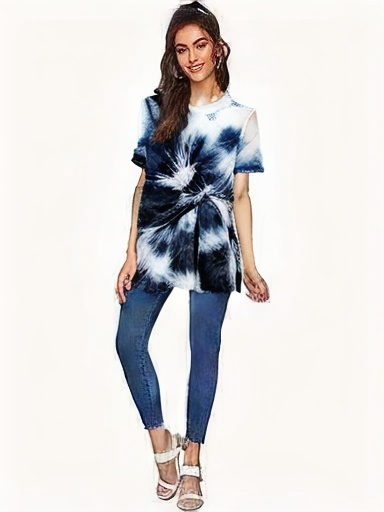

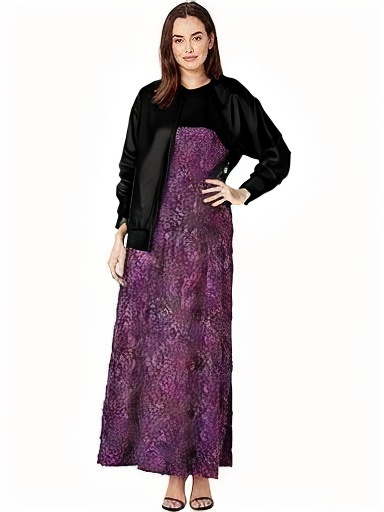

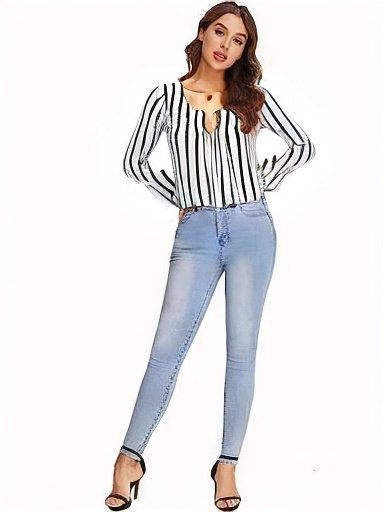

In [49]:
pattern = 'final/upper_body/*'
for images in glob.glob(pattern):
    if images.endswith( dresscode + ".jpg"):
      cv2_imshow(cv2.imread(images, cv2.IMREAD_UNCHANGED))

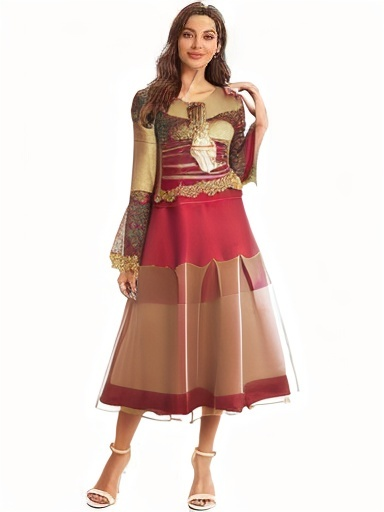

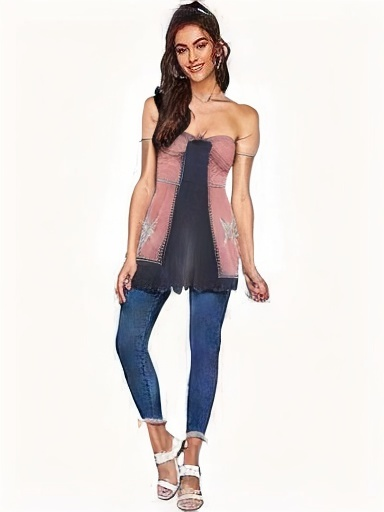

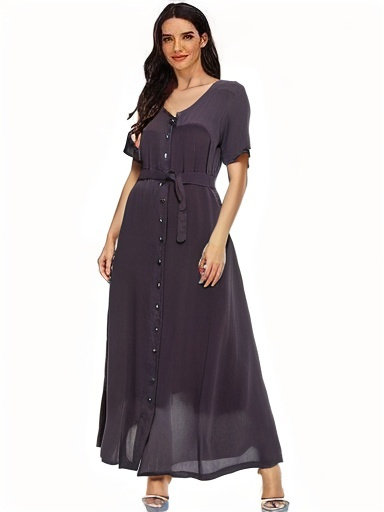

In [50]:
pattern = 'final/dresses/*'
for images in glob.glob(pattern):
    if images.endswith( dresscode + ".jpg"):
      cv2_imshow(cv2.imread(images, cv2.IMREAD_UNCHANGED))